In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from PIL import Image
from skimage import measure, io, color
from skimage.transform import resize, rescale
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import convex_hull_image
from scipy.stats import mode
from sklearn.cluster import DBSCAN, KMeans

os.chdir("/media/ryan/hdd/Dropbox/1_proj/logos/")
# os.chdir("/Users/ryan/Dropbox/1_proj/logos/")

### Helper functions:

In [2]:
def alpha_to_color(image, color=(255, 255, 255)):
    """Alpha composite an RGBA Image with a specified color.

    Simpler, faster version than the solutions above.

    Source: http://stackoverflow.com/a/9459208/284318

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background


def standardize(image):
    if len(image.shape)==2:
        image = color.gray2rgb(image)

    if len(image.shape)>3:
        image = image[:,:,:,0]

    if image.shape[2]==4:
        image = Image.fromarray(image)
        image = alpha_to_color(image)
        image = np.array(image)
        
    return image


def remove_white_bg(img):
    
    img_gray = color.rgb2gray(img)
    
    h, w = tuple(img_gray.shape)

    keep_row = np.zeros(h, dtype='Bool')
    for row in range(h):
        keep_row[row] = (np.sum(np.sum(img_gray[row,:]<0.98,axis=0))>0)

    keep_col = np.ones(w, dtype='Bool')
    for col in range(w):
        keep_col[col] = (np.sum(np.sum(img_gray[:,col]<0.98,axis=0))>0)

    img_nobg = img[keep_row,:]
    img_nobg = img_nobg[:,keep_col]
    
    return img_nobg


def remove_segmentation_bg(img):
      
    h, w = tuple(img.shape)

    keep_row = np.zeros(h, dtype='Bool')
    for row in range(h):
        keep_row[row] = (np.sum(img[row,:])>0)

    keep_col = np.ones(w, dtype='Bool')
    for col in range(w):
        keep_col[col] = (np.sum(img[:,col])>0)

    img_nobg = img[keep_row,:]
    img_nobg = img_nobg[:,keep_col]
    
    return img_nobg


def add_padding(img, bgval, pad_size=20):
    side_pad = np.full((img.shape[0], pad_size, 3), bgval, dtype='uint8')
    tb_pad = np.full((pad_size, img.shape[1] + 2*pad_size, 3), bgval, dtype='uint8')
    padded_img = np.vstack((tb_pad, np.hstack((side_pad, img, side_pad)), tb_pad))
    return padded_img


def add_quantized_padding(img, bgval=0, pad_size=20):
    side_pad = np.full((img.shape[0], pad_size), bgval, dtype='uint8')
    tb_pad = np.full((pad_size, img.shape[1] + 2*pad_size), bgval, dtype='uint8')
    padded_img = np.vstack((tb_pad, np.hstack((side_pad, img, side_pad)), tb_pad))
    return padded_img


def detect_quantized_bg(img):
    from scipy.stats import mode
    corners = np.vstack((np.vstack(img[:10,:10]),np.vstack(img[:10,-10:]),np.vstack(img[-10:,:10]),np.vstack(img[-10:,-10:])))
    rowsums = np.sum(corners, axis=1)
    return mode(corners.flatten())[0][0]


def rescale_img(img, tot_pix=10000):
    h, w = tuple(img.shape[0:2])
    scale_factor = (h*w) / tot_pix
    return resize(img, (np.ceil(h / np.sqrt(scale_factor)).astype('uint8'), np.ceil(w / np.sqrt(scale_factor)).astype('uint8')))


def make_small_feature(feature, end_size = 25, max_size = 100.):

    h, w = tuple(feature.shape[0:2])

    if w==h:
        resized = resize(feature, (max_size, max_size))

    if w>h: 
        scale_factor = w/max_size
        resized = resize(feature, (np.ceil(h/scale_factor), max_size)) 

        padding_amount = max_size - np.ceil(h/scale_factor)
        top_pad = np.floor(padding_amount/2)
        bottom_pad = np.ceil(padding_amount/2)

        resized = np.concatenate([np.zeros((int(top_pad),int(max_size))), 
                                    resized, 
                                    np.zeros((int(bottom_pad),int(max_size)))], axis=0)

    if h>w: 
        scale_factor = h/max_size
        resized = resize(feature, (max_size, np.ceil(w/scale_factor))) 

        padding_amount = max_size - np.ceil(w/scale_factor)
        left_pad = np.floor(padding_amount/2)
        right_pad = np.ceil(padding_amount/2)

        resized = np.concatenate([np.zeros((int(max_size),int(left_pad))), 
                                    resized, 
                                    np.zeros((int(max_size),int(right_pad)))], axis=1)

    resized = resize(resized, (end_size, end_size))
    return resized

### Reuse binary extractor:

In [3]:
def extract_features_from_binary(quantized, style, end_size=25):

    h, w = quantized.shape    
    quantized = add_quantized_padding(quantized)

    sub_labels = label((quantized == 1))

    areas = np.array([region.area for region in regionprops(sub_labels)])
    dot_size = np.sort(areas)[1]
    if style=='glyphic':
        dot_size = 0

    index = 1
    for i in range(1,np.max(sub_labels)+1):
        if areas[i-1] > dot_size:
            if index==1:
                segmentation = np.expand_dims((sub_labels == i), 2)
            else:
                segmentation = np.append(segmentation, np.expand_dims((sub_labels == i), 2), axis=2)
            index += 1

    small_features = np.empty((end_size, end_size, 1))
    for r in range(segmentation.shape[2]):
        cur_small_feat = make_small_feature(remove_segmentation_bg(segmentation[:,:,r]), end_size = end_size)
        if np.any(cur_small_feat < 0.999):
            small_features = np.append(small_features, np.expand_dims(cur_small_feat, axis=2), axis=2)
        
    return small_features[:,:,1:]

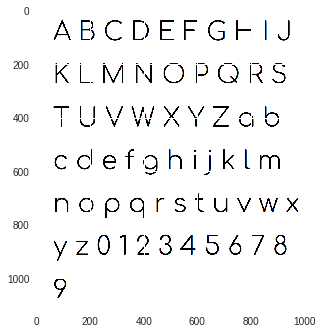

In [9]:
test = io.imread("data/new_sources/font/sans_geom_comfortaa_light.png")
test = standardize(test)
plt.imshow(test, cmap='gray')

62


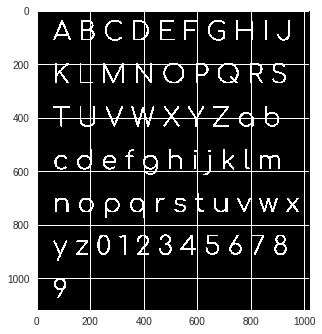

In [10]:
binary_test = np.sum(test, axis=2) < 765
plt.imshow(binary_test, cmap='gray')

small_features = extract_features_from_binary(binary_test, style='NA')
print(small_features.shape[2])

/home/ryan/anaconda/envs/clusterenv/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


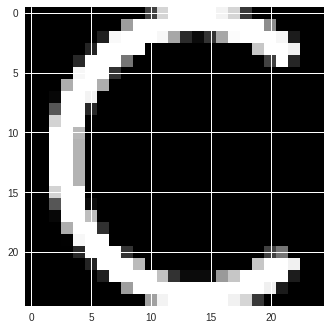

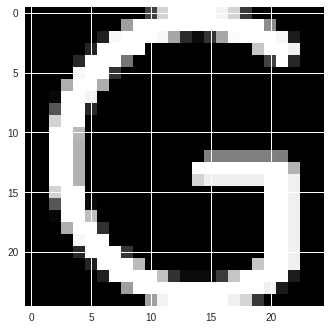

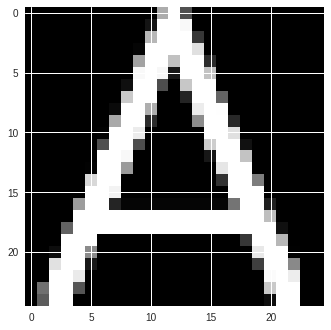

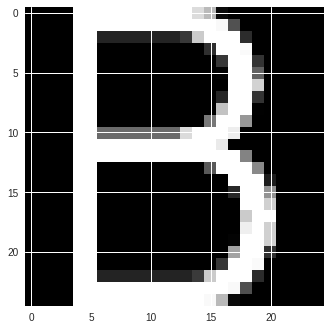

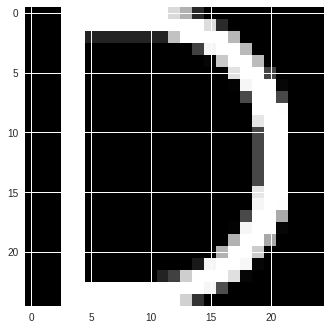

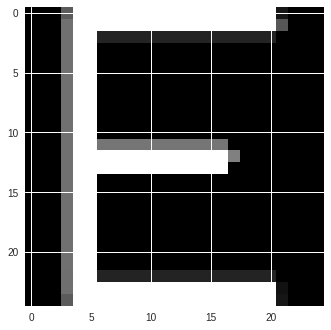

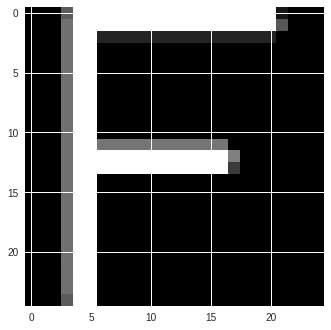

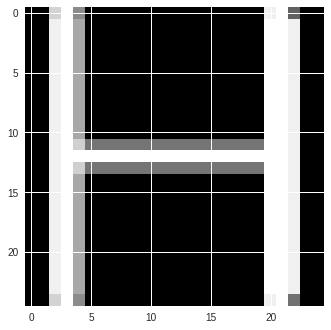

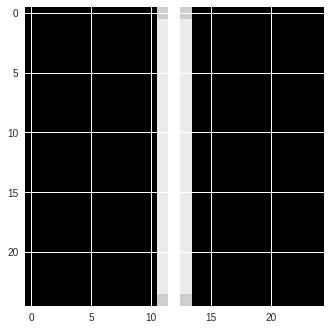

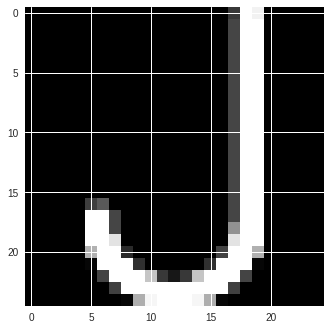

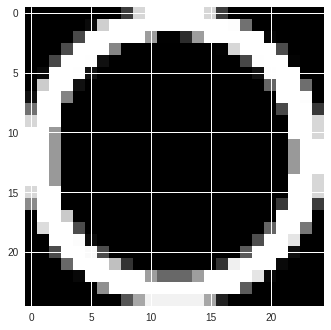

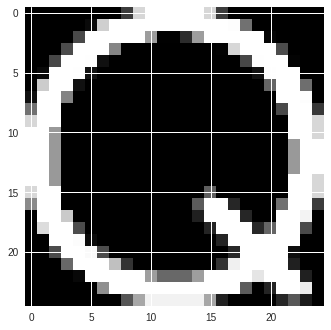

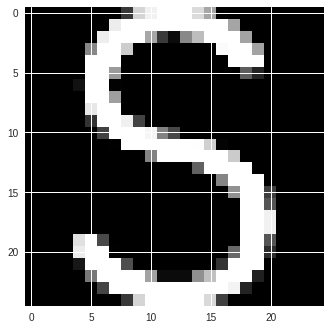

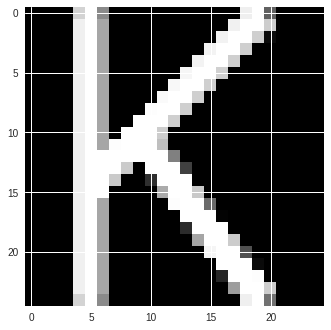

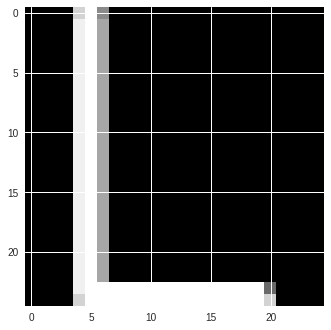

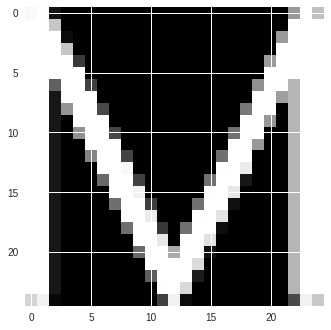

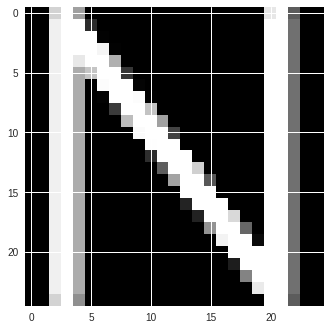

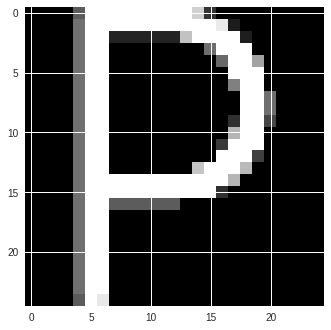

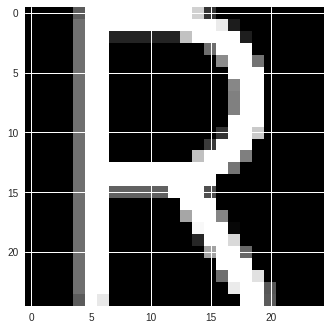

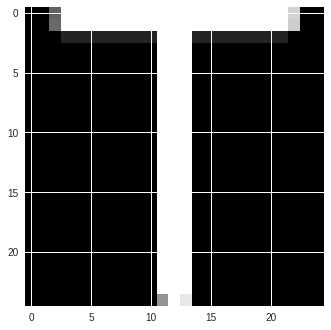

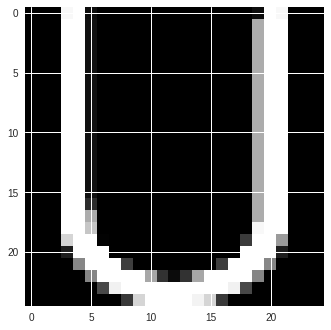

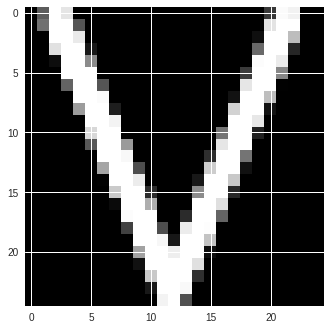

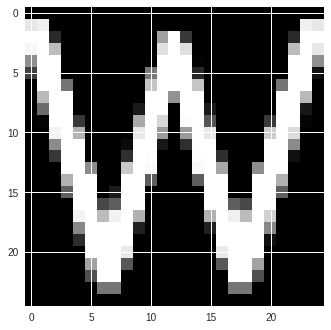

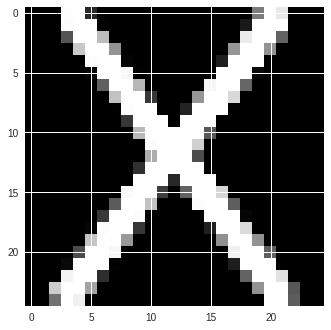

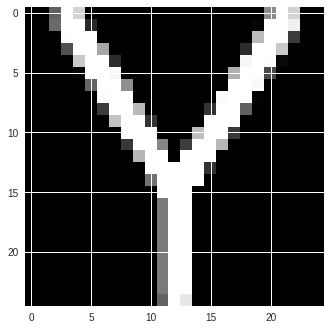

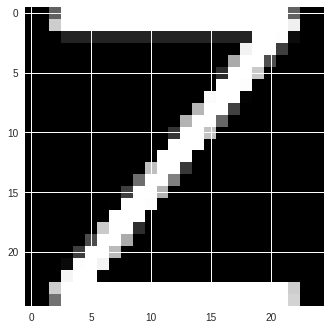

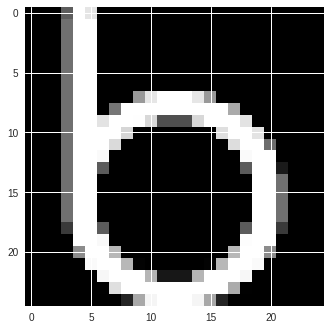

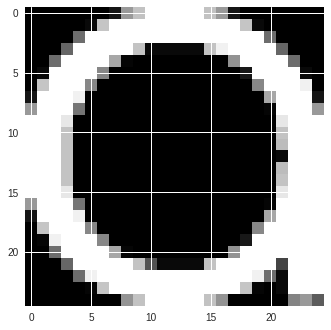

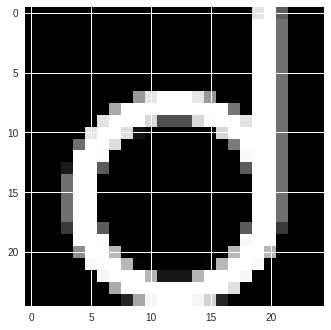

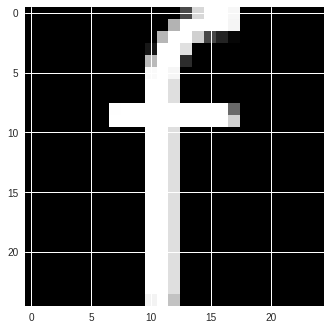

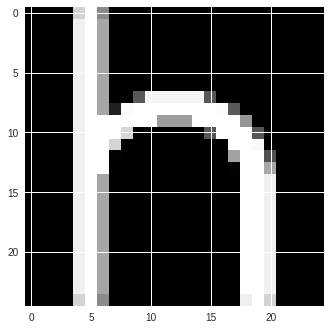

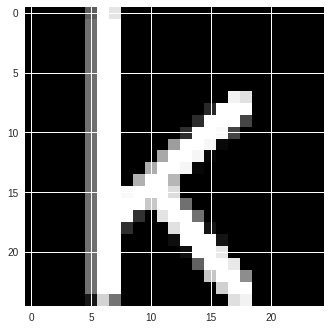

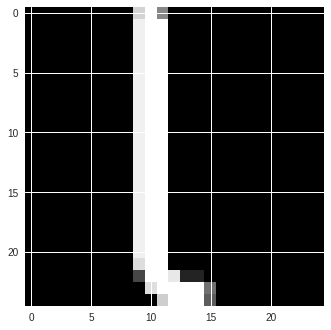

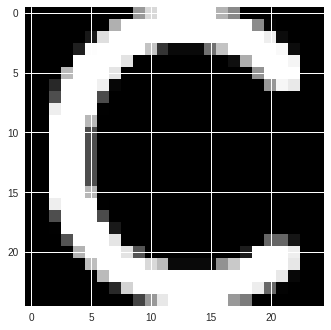

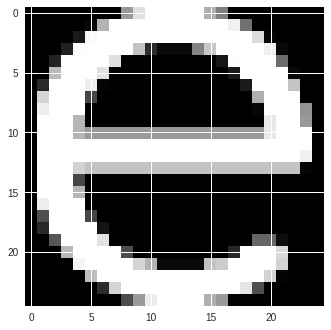

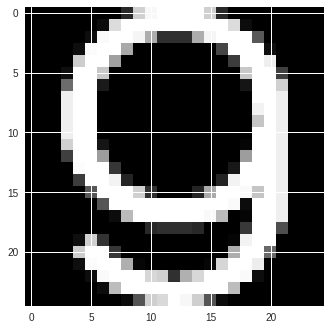

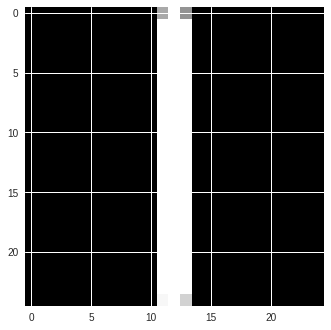

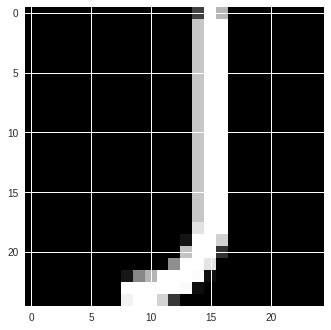

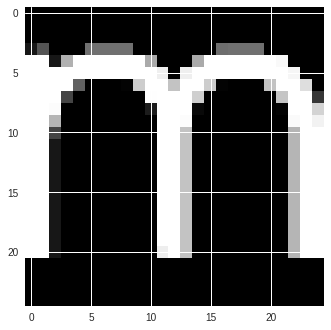

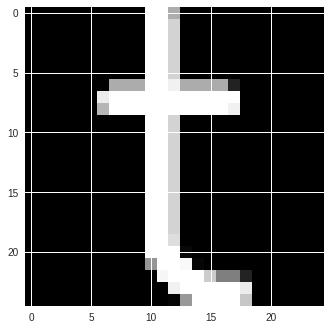

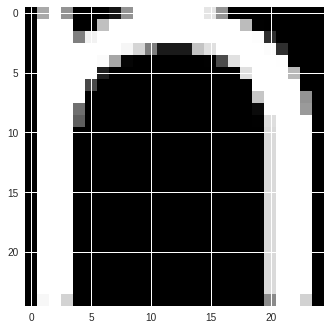

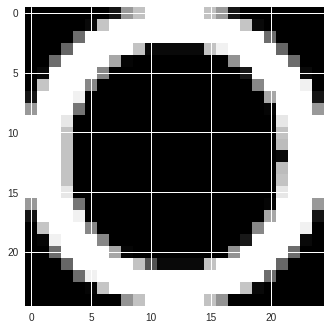

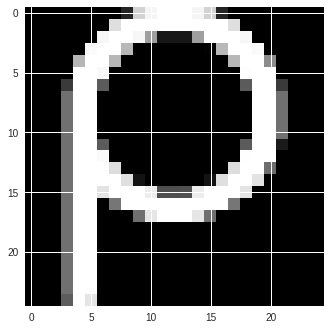

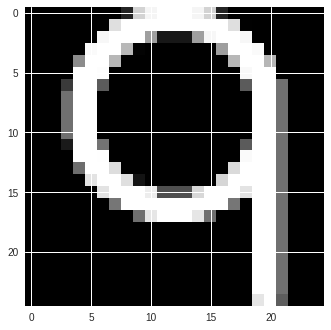

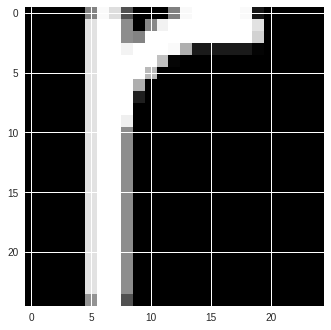

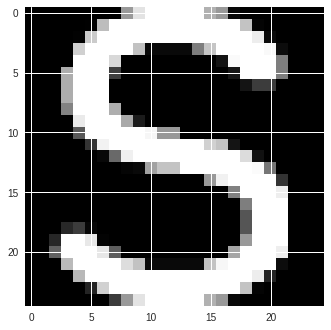

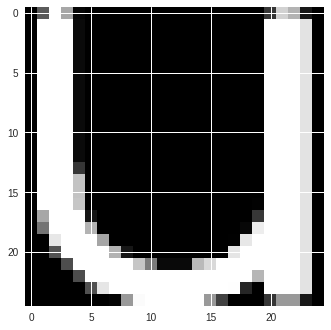

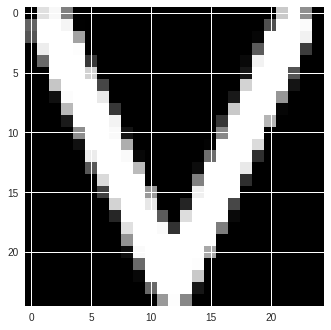

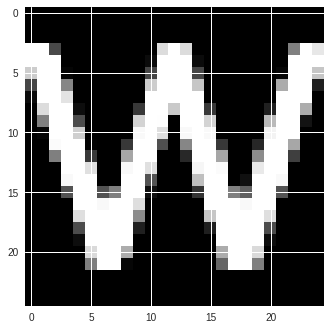

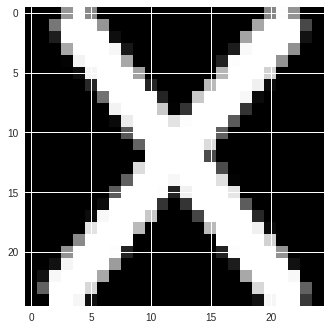

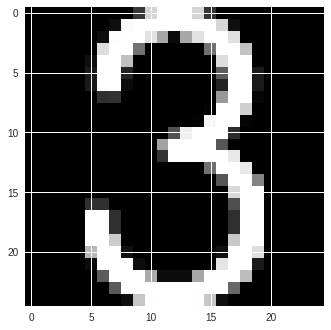

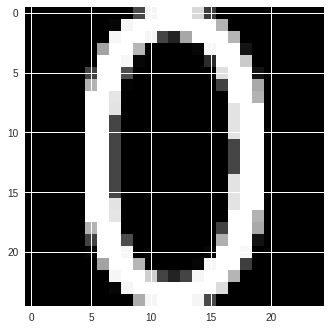

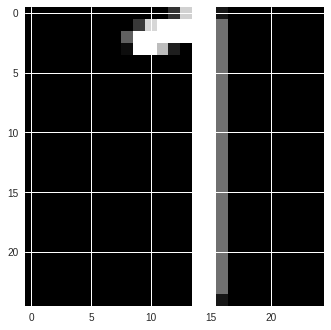

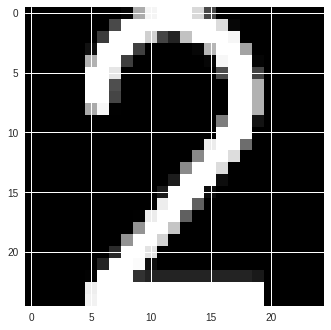

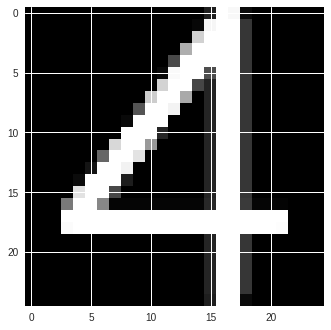

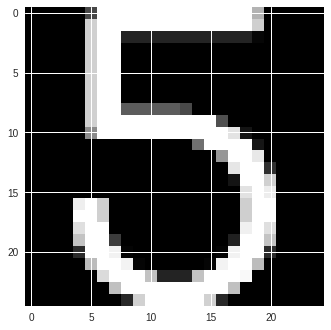

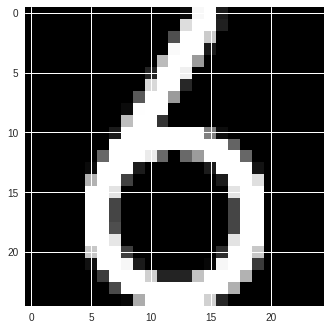

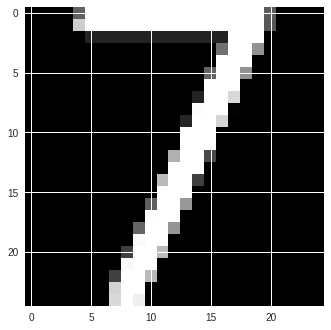

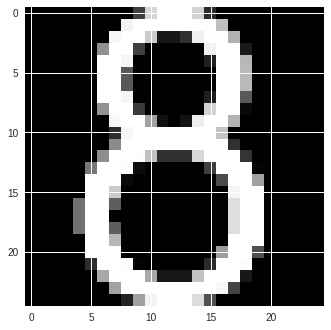

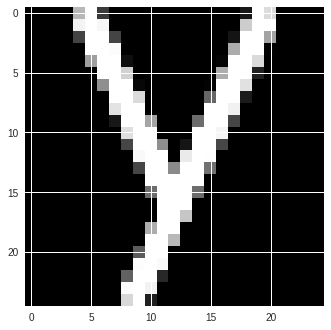

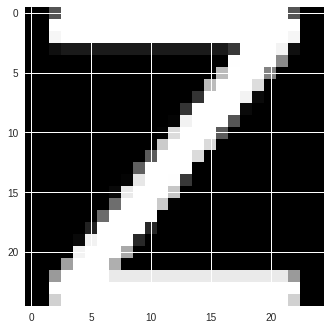

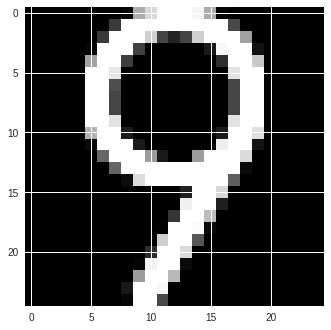

In [11]:
for s in range(small_features.shape[2]):
    plt.figure()
    plt.imshow(small_features[:,:,s], cmap='gray')

## Do the extraction for all fonts:

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

index = 1
for font in os.listdir("data/new_sources/font/"):
    if font == ".DS_Store":
        continue
    
    print("\r",index,font,"    ")
    font_fam = font.split(("."))[0]
    ftype, style, family, ver = font_fam.split("_")
    
    font_img = standardize(io.imread("data/new_sources/font/" + font))
    font_binary = np.sum(font_img, axis=2) < 765
    
    small_features = extract_features_from_binary(font_binary, style=style)
    h, w, d = small_features.shape
    tempdf = pd.DataFrame(np.transpose(np.reshape(small_features, (h*w, d))))
    tempdf['ftype'] = ftype
    tempdf['style'] = style
    tempdf['family'] = family
    tempdf['ver'] = ver

    if index==1:
        fontdf = tempdf
    else:
        fontdf = pd.concat([fontdf, tempdf])
    
    index += 1
        

 1 sans_geom_futura_ci.png     
 2 sans_geom_comfortaa_bold.png     
 3 serif_oldstyle_centaur_orig.png     
 4 serif_transitional_times_orig.png     
 5 serif_transitional_times_cb.png     
 6 serif_transitional_times_italic.png     
 7 callig_glyphic_copperplate-gothic_orig.png     
 8 callig_casual_nadianne_bold.png     
 9 serif_didone_bodoni_italic.png     
 10 sans_humanist_gillsans_bold.png     
 11 serif_transitional_times_bold.png     
 12 serif_transitional_americana_orig.png     
 13 sans_grotesque_helvetica_light.png     
 14 serif_oldstyle_centaur_bi.png     
 15 serif_oldstyle_centaur_bold.png     
 16 serif_didone_bodoni_bold.png     
 17 serif_slab_rockwell_co.png     
 18 sans_humanist_gillsans_italic.png     
 19 serif_didone_bodoni_orig.png     
 20 sans_humanist_gillsans_co.png     
 21 sans_geom-square_eurostile_co.png     
 22 serif_oldstyle_bembo_bi.png     
 23 serif_oldstyle_bembo_orig.png     
 24 callig_casual_nadianne_orig.png     
 25 serif_didone_bodoni_cb

In [13]:
fontdf.to_csv("data/new_sources/font_features.csv", index=False)